This notebook performs comprehensive exploratory data analysis (EDA) and quality assessment on the processed data from the previous step.

## Objectives
- Assess data quality and identify issues
- Explore feature distributions and relationships
- Analyze class balance and separability
- Generate quality metrics and recommendations
- Prepare data for modeling phase

All parameters are managed through `config.toml` for reproducibility and consistency.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from pathlib import Path
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import toml

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load configuration
config = toml.load('../config.toml')
sample_id_col = config['data']['sample_id_column']
label_col = config['data']['label_column']

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])

# Display configuration
print("Configuration loaded:")
print(f"Data input: {config['data']['input_path']}")
print(f"Label column: {config['data']['label_column']}")
print(f"Outlier method: {config['preprocessing']['outlier_method']}")
print(f"Visualization DPI: {config['visualization']['dpi']}")

Configuration loaded:
Data input: ../data/test_input.csv
Label column: label
Outlier method: iqr
Visualization DPI: 300


## Load Data

In [2]:
# Load processed data from previous step
data_dir = Path('../data/processed')

# Load all pickle files
with open(data_dir / '01_data_ingestion.pkl', 'rb') as f:
    data_objects = pickle.load(f)

# Extract key objects
df = data_objects["data"]['df']
feature_cols = data_objects["data"]['feature_cols']

# Display basic information
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(df)}")
print(f"Classes: {df[label_col].nunique()}")
print(f"Label distribution:\n{df[label_col].value_counts()}")

Dataset Information:
Shape: (30, 32)
Features: 30
Samples: 30
Classes: 3
Label distribution:
label
A    10
B    10
C    10
Name: count, dtype: int64


## Data Quality Assessment

We'll systematically assess data quality across multiple dimensions:
- Missing values
- Data types and ranges
- Duplicates
- Outliers
- Data consistency

In [3]:
# Missing values analysis
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

print("Missing Values Analysis:")
print("=" * 50)

# Overall missing values
total_missing = missing_data.sum()
total_missing_percent = (total_missing / (len(df) * len(df.columns))) * 100

print(f"Total missing values: {total_missing}")
print(f"Overall missing percentage: {total_missing_percent:.2f}%")

# Features with missing values
features_with_missing = missing_data[missing_data > 0]
if len(features_with_missing) > 0:
    print(f"\nFeatures with missing values ({len(features_with_missing)}):")
    for feature, count in features_with_missing.items():
        print(f"  {feature}: {count} ({missing_percent[feature]:.2f}%)")
else:
    print("\nNo missing values found in any feature.")

# Visualize missing values
if total_missing > 0:
    plt.figure(figsize=tuple(config['visualization']['figure_size']))
    missing_percent.plot(kind='bar')
    plt.title('Missing Values by Feature')
    plt.xlabel('Features')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Missing Values Analysis:
Total missing values: 0
Overall missing percentage: 0.00%

No missing values found in any feature.


In [4]:
# Data types and ranges analysis
print("Data Types and Ranges Analysis:")
print("=" * 50)

# Data types
print("\nData Types:")
print(df.dtypes.value_counts())

# Numeric features summary
numeric_features = df[feature_cols].select_dtypes(include=[np.number])
print(f"\nNumeric features: {len(numeric_features.columns)}")

# Statistical summary
print("\nStatistical Summary of Features:")
print(numeric_features.describe())

# Check for infinite values
infinite_counts = np.isinf(numeric_features).sum()
if infinite_counts.sum() > 0:
    print(f"\nInfinite values found: {infinite_counts.sum()}")
    for col, count in infinite_counts[infinite_counts > 0].items():
        print(f"  {col}: {count}")
else:
    print("\nNo infinite values found.")

# Value ranges
print("\nValue Ranges:")
for col in feature_cols:
    col_data = df[col].dropna()
    if len(col_data) > 0:
        print(f"{col}: [{col_data.min():.3f}, {col_data.max():.3f}]")

Data Types and Ranges Analysis:

Data Types:
float64    30
object      2
Name: count, dtype: int64

Numeric features: 30

Statistical Summary of Features:
       feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean    0.048433  -0.008667  -0.170967   0.239933  -0.021333   0.062067   
std     0.757390   1.095838   0.906935   0.844099   0.833051   1.222434   
min    -1.692000  -1.710000  -1.606000  -1.402000  -2.472000  -2.211000   
25%    -0.449500  -0.906000  -1.049750  -0.402250  -0.565250  -0.773250   
50%     0.003000  -0.162000  -0.133500   0.392000   0.072500  -0.165500   
75%     0.513500   0.965500   0.523750   0.720000   0.632000   0.758000   
max     2.061000   1.852000   1.447000   1.831000   1.179000   2.632000   

       feature_7  feature_8  feature_9  feature_10  ...  feature_21  \
count   30.00000  30.000000  30.000000   30.000000  ...   30.000000   
mean     0.07910   0.022400

In [5]:
# Duplicate detection
print("Duplicate Detection:")
print("=" * 50)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
duplicate_percent = (duplicate_rows / len(df)) * 100

print(f"Duplicate rows: {duplicate_rows} ({duplicate_percent:.2f}%)")

# Check for duplicate feature values
duplicate_features = []
for col in feature_cols:
    unique_ratio = df[col].nunique() / len(df)
    if unique_ratio < 0.1:  # Less than 10% unique values
        duplicate_features.append((col, unique_ratio))

if duplicate_features:
    print(f"\nFeatures with low uniqueness ({len(duplicate_features)}):")
    for feature, ratio in duplicate_features:
        print(f"  {feature}: {ratio:.3f} unique ratio")
else:
    print("\nAll features have good uniqueness.")

# Check for duplicate sample IDs (if present)
if sample_id_col and sample_id_col in df.columns:
    duplicate_ids = df[sample_id_col].duplicated().sum()
    if duplicate_ids > 0:
        print(f"\nDuplicate sample IDs: {duplicate_ids}")
    else:
        print("\nNo duplicate sample IDs found.")

Duplicate Detection:
Duplicate rows: 0 (0.00%)

All features have good uniqueness.

No duplicate sample IDs found.


In [6]:
# Outlier detection using configured method
print("Outlier Detection:")
print("=" * 50)

outlier_method = config['preprocessing']['outlier_method']
print(f"Using method: {outlier_method}")

# Prepare data for outlier detection
X = df[feature_cols].fillna(df[feature_cols].mean())

outliers_by_feature = {}
total_outliers = 0

if outlier_method == "iqr":
    # IQR method
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    for col in feature_cols:
        outliers = ((X[col] < lower_bound[col]) | (X[col] > upper_bound[col])).sum()
        outliers_by_feature[col] = outliers
        total_outliers += outliers

elif outlier_method == "zscore":
    # Z-score method
    z_scores = np.abs(stats.zscore(X))
    threshold = 3.0
    
    for col in feature_cols:
        outliers = (z_scores[:, feature_cols.index(col)] > threshold).sum()
        outliers_by_feature[col] = outliers
        total_outliers += outliers

elif outlier_method == "isolation_forest":
    # Isolation Forest method
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outlier_labels = iso_forest.fit_predict(X)
    outliers = (outlier_labels == -1).sum()
    total_outliers = outliers
    outliers_by_feature = {"Overall": outliers}

print(f"Total outliers detected: {total_outliers}")
print(f"Outlier percentage: {(total_outliers / (len(df) * len(feature_cols))) * 100:.2f}%")

# Show features with most outliers
if outlier_method != "isolation_forest":
    top_outlier_features = sorted(outliers_by_feature.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 features with most outliers:")
    for feature, count in top_outlier_features:
        if count > 0:
            print(f"  {feature}: {count}")

Outlier Detection:
Using method: iqr
Total outliers detected: 11
Outlier percentage: 1.22%

Top 10 features with most outliers:
  feature_11: 2
  feature_19: 2
  feature_30: 2
  feature_1: 1
  feature_5: 1
  feature_9: 1
  feature_13: 1
  feature_29: 1


## Feature Analysis

We'll analyze feature distributions, correlations, and importance to understand the data structure and identify patterns.

Correlation Analysis:
Features with correlation > 0.8: 0


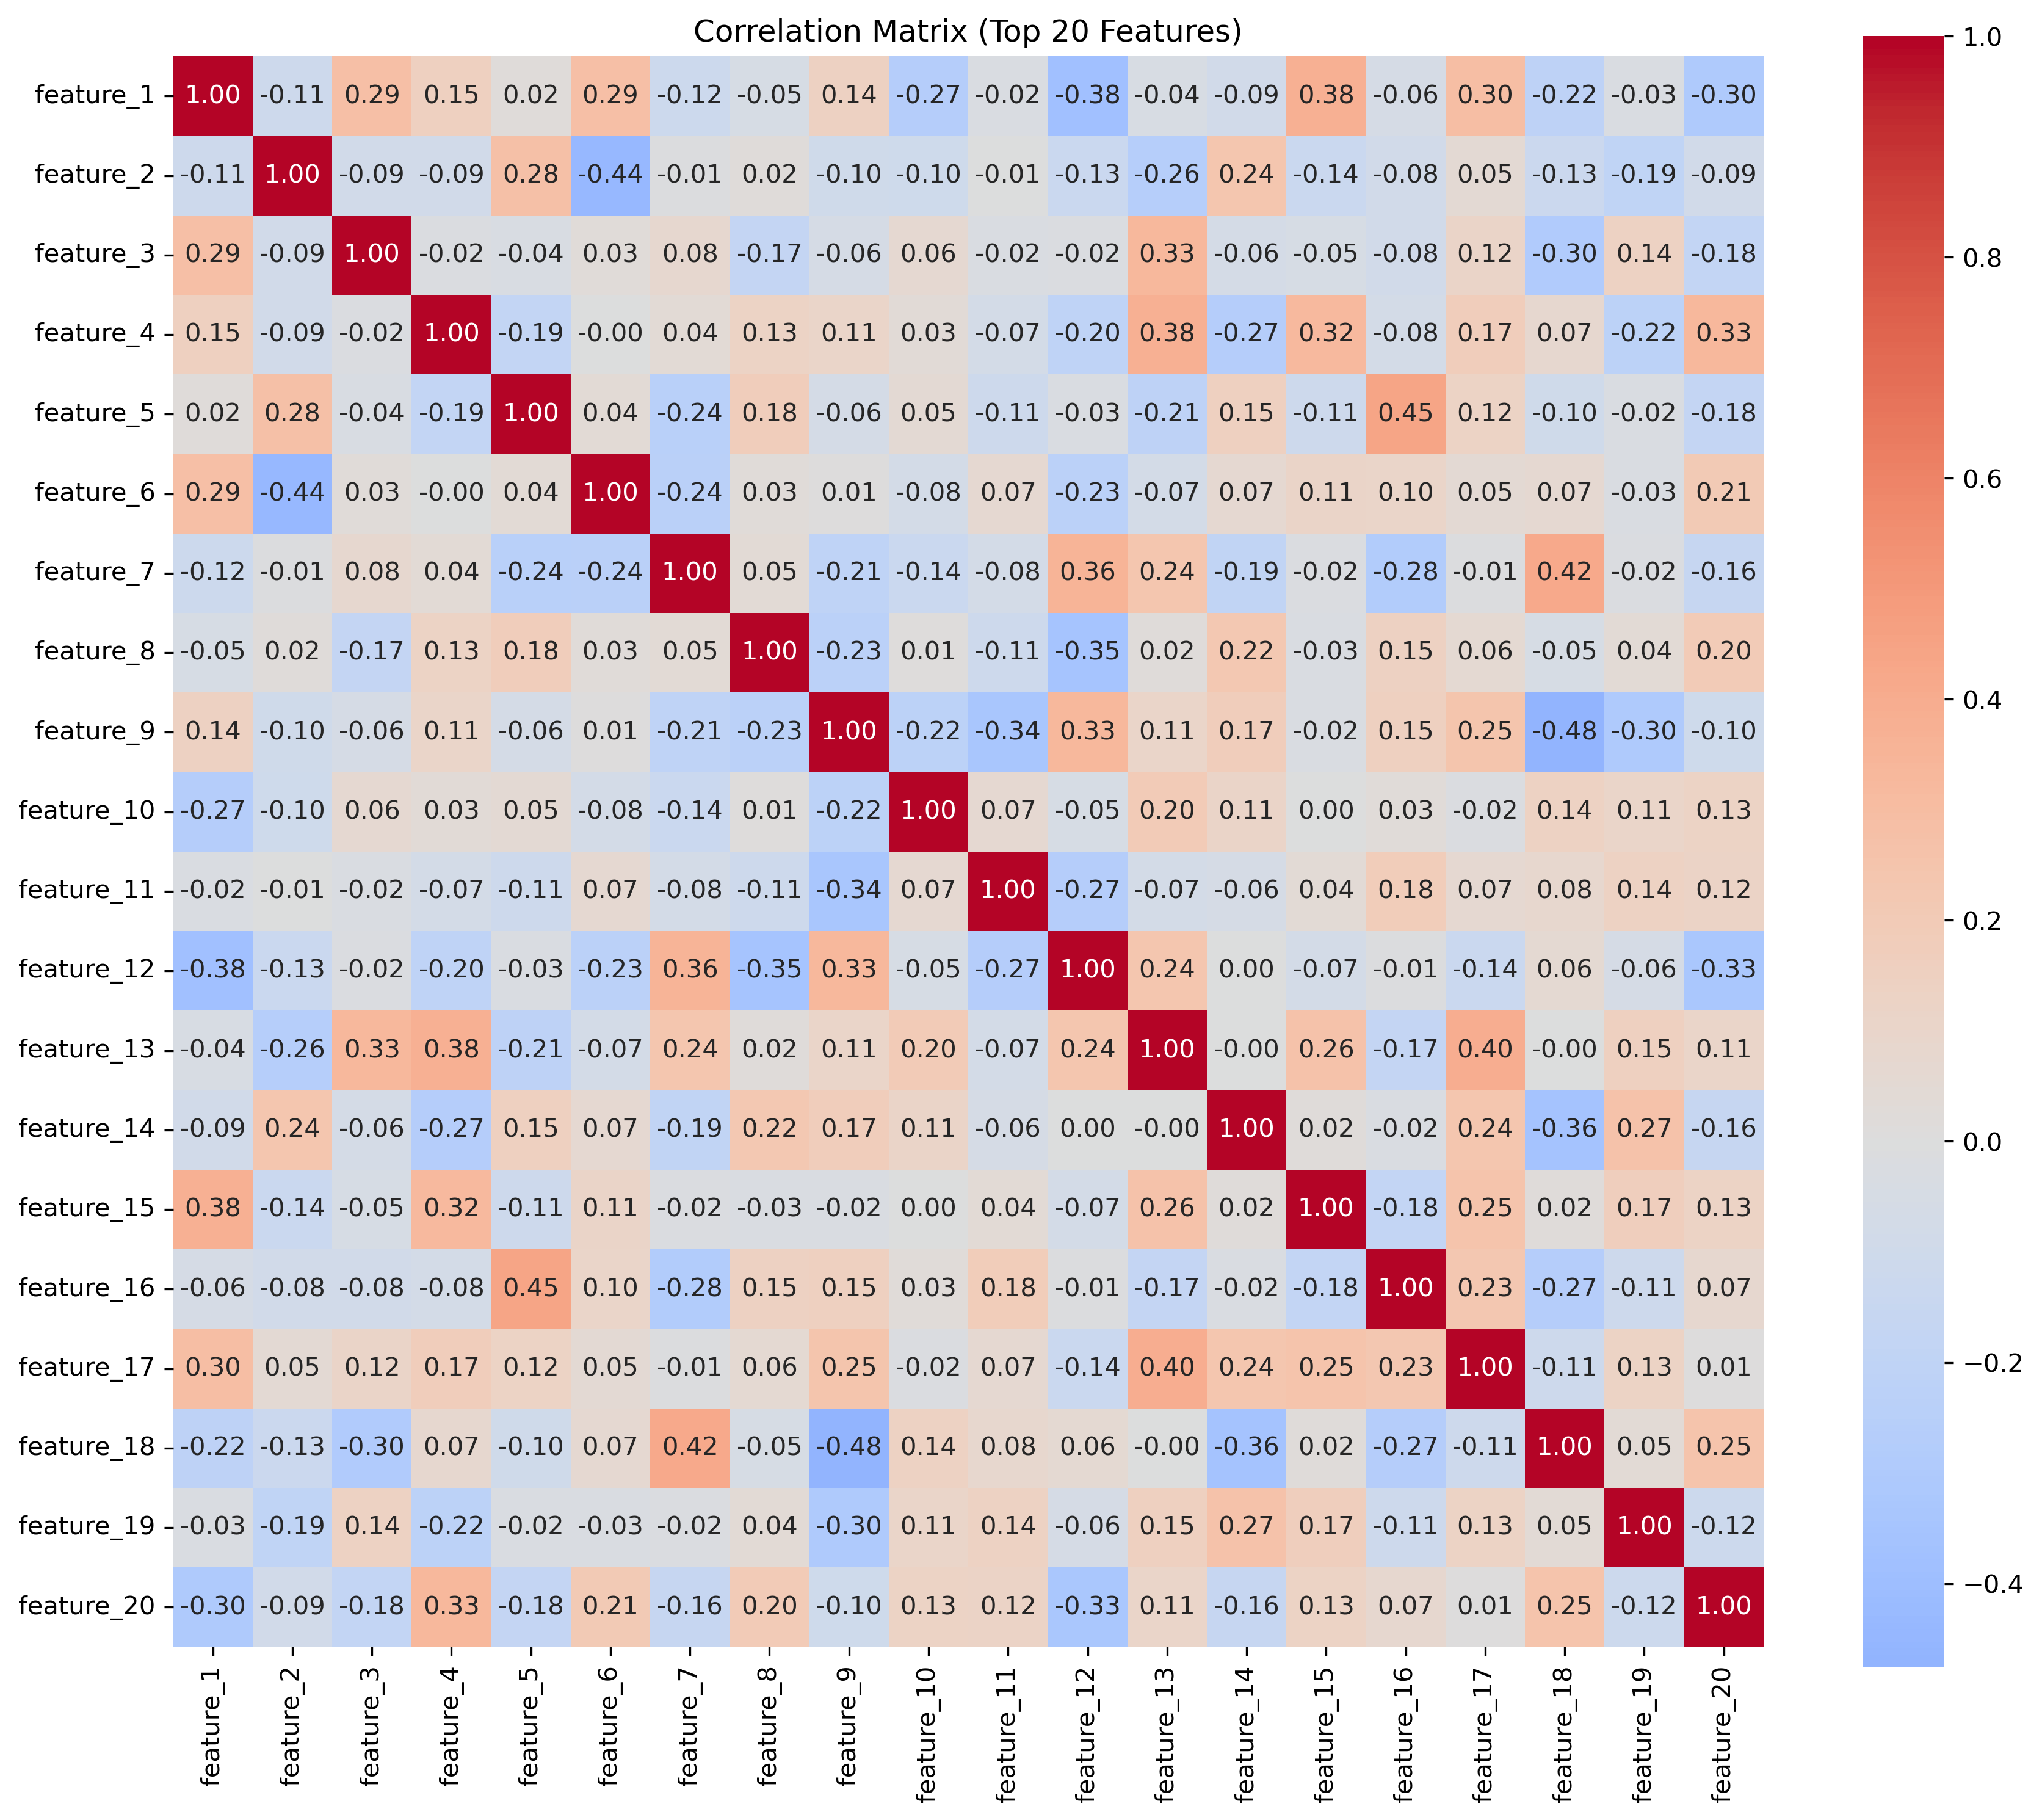


Feature Variance Analysis:
Top 10 features by variance:
  feature_15: 1.710839
  feature_6: 1.494346
  feature_23: 1.453977
  feature_30: 1.277082
  feature_2: 1.200861
  feature_14: 1.200254
  feature_11: 1.188535
  feature_17: 1.141693
  feature_22: 1.091827
  feature_25: 1.078689


In [7]:
# Correlation analysis
print("Correlation Analysis:")
print("=" * 50)

# Calculate correlation matrix
correlation_matrix = df[feature_cols].corr()

# Find highly correlated features
threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

print(f"Features with correlation > {threshold}: {len(high_corr_pairs)}")

if high_corr_pairs:
    print("\nHighly correlated feature pairs:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"  {feat1} - {feat2}: {corr:.3f}")

# Visualize correlation matrix (top features)
n_corr_features = min(20, len(feature_cols))
top_features = feature_cols[:n_corr_features]

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title(f'Correlation Matrix (Top {n_corr_features} Features)')
plt.tight_layout()
plt.show()

# Feature variance analysis
print("\nFeature Variance Analysis:")
variances = df[feature_cols].var().sort_values(ascending=False)
print("Top 10 features by variance:")
for feature, var in variances.head(10).items():
    print(f"  {feature}: {var:.6f}")

## Label Analysis

We'll analyze the target variable distribution and explore how features relate to different classes.

Label Analysis:
Class Distribution:
  A: 10 (33.3%)
  B: 10 (33.3%)
  C: 10 (33.3%)


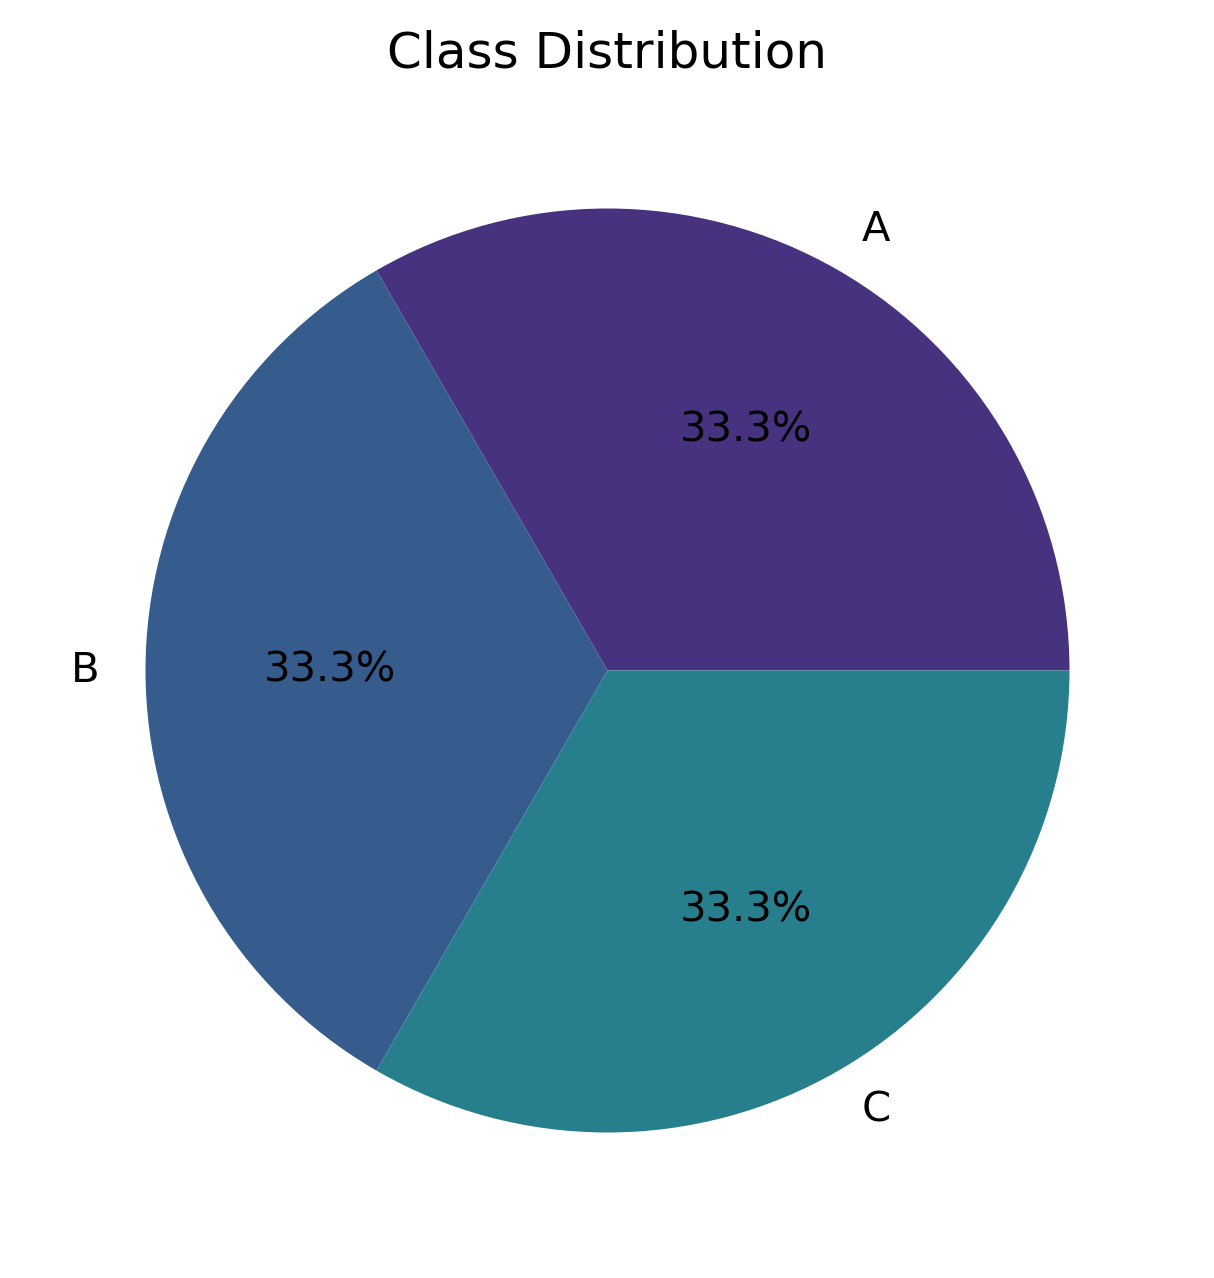


Class Balance Assessment:
Number of classes: 3
Smallest class: 10
Largest class: 10
Balance ratio: 1.000
✓ Classes are reasonably balanced.


In [8]:
# Class distribution analysis
print("Label Analysis:")
print("=" * 50)

# Class distribution
class_counts = df[label_col].value_counts()
class_percentages = (class_counts / len(df)) * 100

print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} ({class_percentages[class_name]:.1f}%)")

# Visualize class distribution
plt.figure(figsize=tuple(config['visualization']['figure_size']))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

# Class balance assessment
n_classes = len(class_counts)
min_class_size = class_counts.min()
max_class_size = class_counts.max()
balance_ratio = min_class_size / max_class_size

print(f"\nClass Balance Assessment:")
print(f"Number of classes: {n_classes}")
print(f"Smallest class: {min_class_size}")
print(f"Largest class: {max_class_size}")
print(f"Balance ratio: {balance_ratio:.3f}")

if balance_ratio < 0.3:
    print("⚠️  Severe class imbalance detected!")
elif balance_ratio < 0.5:
    print("⚠️  Moderate class imbalance detected.")
else:
    print("✓ Classes are reasonably balanced.")

In [9]:
from sklearn.feature_selection import f_classif
import numpy as np

print(f"\nSelecting top features based on class-wise variation...")

# Drop rows with NaNs in features
X = df[feature_cols].dropna()
y = df.loc[X.index, label_col]

# Compute F-statistics for each feature
f_scores, _ = f_classif(X, y)

# Rank features by F-score
top_indices = np.argsort(f_scores)[::-1]  # descending order
top_features = [feature_cols[i] for i in top_indices[:10]]

print("Top 10 informative features by ANOVA F-score:")
for i, f in enumerate(top_features):
    print(f"  {i+1}. {f} (F-score = {f_scores[feature_cols.index(f)]:.2f})")


Selecting top features based on class-wise variation...
Top 10 informative features by ANOVA F-score:
  1. feature_6 (F-score = 3.02)
  2. feature_10 (F-score = 2.69)
  3. feature_14 (F-score = 1.97)
  4. feature_24 (F-score = 1.77)
  5. feature_7 (F-score = 1.73)
  6. feature_5 (F-score = 1.68)
  7. feature_1 (F-score = 1.31)
  8. feature_9 (F-score = 1.30)
  9. feature_19 (F-score = 1.04)
  10. feature_21 (F-score = 1.03)


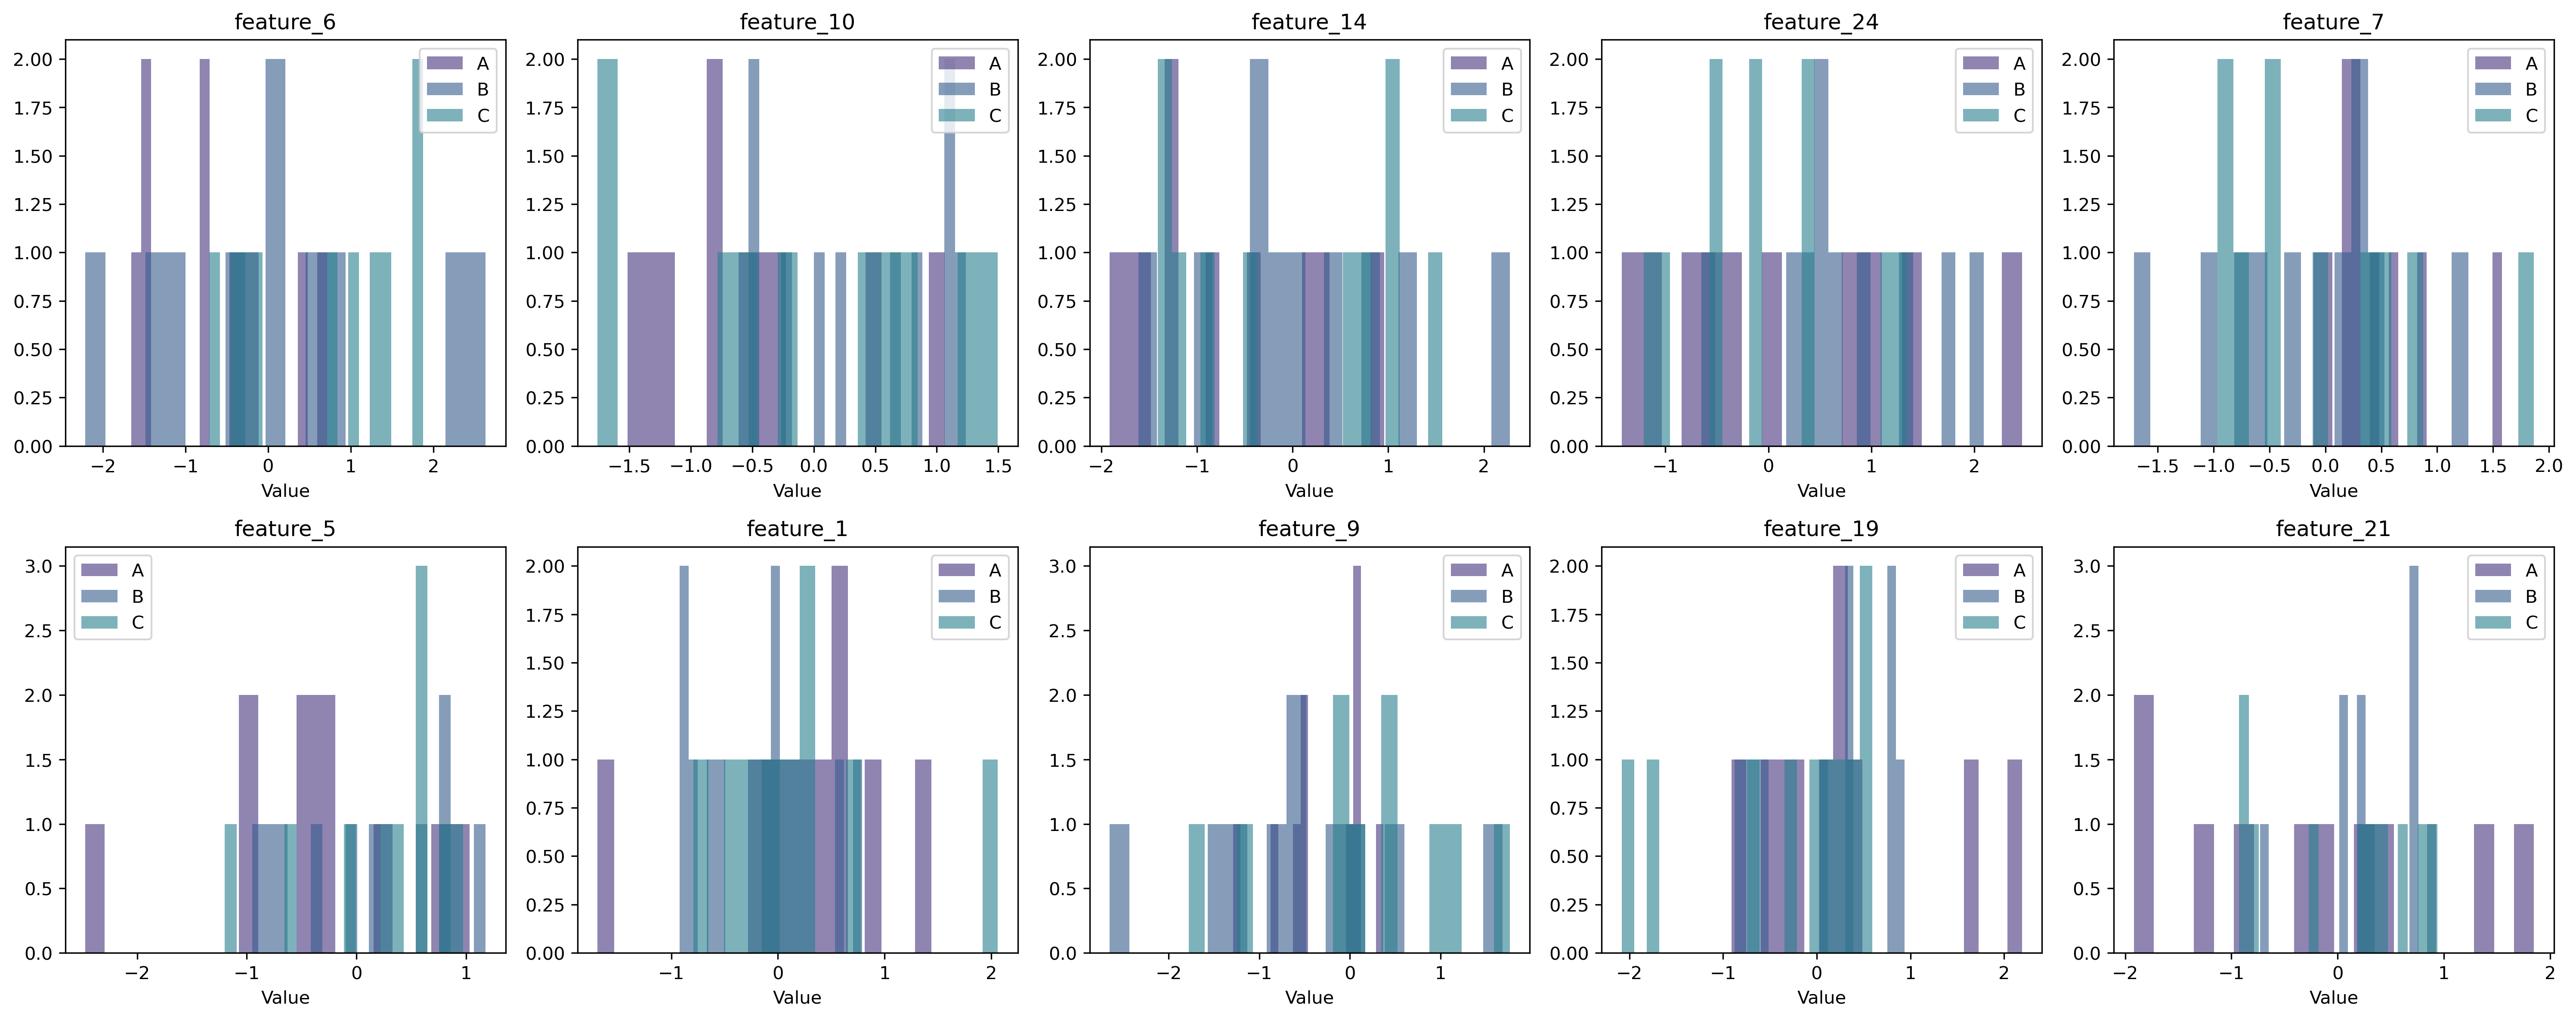

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    for class_name in df[label_col].unique():
        class_data = df[df[label_col] == class_name][feature].dropna()
        axes[i].hist(class_data, alpha=0.6, label=class_name, bins=20)
    
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('Value')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Data Quality Report

Based on our comprehensive analysis, here's a summary of data quality findings and recommendations.

In [11]:
# Generate quality report
print("Data Quality Report:")
print("=" * 50)

# Calculate quality metrics
quality_metrics = {
    'missing_values_percent': total_missing_percent,
    'duplicate_rows_percent': duplicate_percent,
    'outlier_percent': (total_outliers / (len(df) * len(feature_cols))) * 100,
    'class_balance_ratio': balance_ratio,
    'high_correlation_pairs': len(high_corr_pairs),
    'features_with_low_uniqueness': len(duplicate_features)
}

print("Quality Metrics:")
for metric, value in quality_metrics.items():
    print(f"  {metric}: {value:.3f}")

# Generate recommendations
recommendations = []

if quality_metrics['missing_values_percent'] > 5:
    recommendations.append("Consider imputation strategy for missing values")
    
if quality_metrics['duplicate_rows_percent'] > 1:
    recommendations.append("Remove or investigate duplicate rows")
    
if quality_metrics['outlier_percent'] > 10:
    recommendations.append("Consider outlier treatment strategy")
    
if quality_metrics['class_balance_ratio'] < 0.3:
    recommendations.append("Use class balancing techniques (SMOTE, class weights)")
    
if quality_metrics['high_correlation_pairs'] > 10:
    recommendations.append("Consider feature selection to remove highly correlated features")
    
if quality_metrics['features_with_low_uniqueness'] > 0:
    recommendations.append("Investigate features with low uniqueness")

print(f"\nRecommendations ({len(recommendations)}):")
for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. {rec}")

# Overall quality score
quality_score = 100
if quality_metrics['missing_values_percent'] > 5:
    quality_score -= 20
if quality_metrics['duplicate_rows_percent'] > 1:
    quality_score -= 15
if quality_metrics['outlier_percent'] > 10:
    quality_score -= 15
if quality_metrics['class_balance_ratio'] < 0.3:
    quality_score -= 10
if quality_metrics['high_correlation_pairs'] > 10:
    quality_score -= 10

print(f"\nOverall Data Quality Score: {quality_score}/100")
if quality_score >= 80:
    print("✓ Excellent data quality")
elif quality_score >= 60:
    print("✓ Good data quality")
elif quality_score >= 40:
    print("⚠️  Moderate data quality issues")
else:
    print("⚠️  Significant data quality issues")

Data Quality Report:
Quality Metrics:
  missing_values_percent: 0.000
  duplicate_rows_percent: 0.000
  outlier_percent: 1.222
  class_balance_ratio: 1.000
  high_correlation_pairs: 0.000
  features_with_low_uniqueness: 0.000

Recommendations (0):

Overall Data Quality Score: 100/100
✓ Excellent data quality


## Save Analysis Results

We'll save the analysis results and quality assessment for use in subsequent notebooks.

In [12]:
# Save analysis results
import pickle
from datetime import datetime

# Create output directory
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Prepare results to save
eda_results = {
    'quality_metrics': quality_metrics,
    'recommendations': recommendations,
    'quality_score': quality_score,
    'correlation_matrix': correlation_matrix,
    'high_corr_pairs': high_corr_pairs,
    'outliers_by_feature': outliers_by_feature,
    'class_distribution': class_counts.to_dict(),
    'feature_variances': variances.to_dict(),
    'analysis_timestamp': datetime.now().isoformat()
}

# Save results
with open(output_dir / '02_eda_results.pkl', 'wb') as f:
    pickle.dump(eda_results, f)